# Mixtures of MCs -- Testbed

In [1]:
import sys
# setting path
sys.path.append('../core')

from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

import numba
from numba import jit, njit

import tqdm
from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')


import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy

import confound_mdp
import confound_ope
import confound_env
import copy

from subspace import *
from clustering import *
from emalg import *
from helpers import *

%matplotlib inline
plt.style.use('matplotlibrc')

2023-05-27 19:48:42.355041: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-27 19:48:42.376209: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 19:48:42.647054: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
genres = pd.read_csv('Lastfm-ArtistTags2007/tags.txt', header=None)[0].values[:100]
genres = pd.DataFrame([genre.split()[0] for genre in genres], 
             index = [' '.join(genre.split()[1:]) for genre in genres],
            columns = ['count'])
genres.head()

,count
rock,440854
seen live,343901
indie,277747
alternative,245259
metal,184491


In [3]:
users = pd.read_csv("lastfm-dataset-1K/userid-profile.tsv", sep="\t")
users.head()

,#id,gender,age,country,registered
0,user_000001,m,NaN,Japan,"Aug 13, 2006"
1,user_000002,f,NaN,Peru,"Feb 24, 2006"
2,user_000003,m,22.0,United States,"Oct 30, 2005"
3,user_000004,f,NaN,NaN,"Apr 26, 2006"
4,user_000005,m,NaN,Bulgaria,"Jun 29, 2006"


In [4]:
lastfm = pd.read_csv("lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv", sep="\t", 
           header=None, on_bad_lines='skip')
lastfm.columns = ['userid', 'timestamp', 'artistid', 'artistname', 'trackid', 'trackname']
topusers = lastfm.groupby('userid').size().sort_values()[-10:]
lastfm = lastfm[[user in topusers for user in lastfm['userid']]]
lastfm.timestamp = pd.to_datetime(lastfm['timestamp'])

In [5]:
tags = pd.read_table('Lastfm-ArtistTags2007/ArtistTags.dat', sep="<sep>", header=None, on_bad_lines='skip')
tags.columns = ['artistid', 'artistname', 'tagname', 'rawtagcount']
tags = tags[[tag in genres.index for tag in tags['tagname']]]
# there are multiple tags/genres assigned to each artist.
#  for simplicity, pick the tag/genre most associated with each artist
#  by ranking by raw tag count and picking the first
tags = tags[tags.groupby(['artistid', 'artistname'])['rawtagcount'].rank(method='first', ascending=False) <= 1]

In [6]:
dataset = lastfm.merge(tags, on='artistid').sort_values(['userid', 'timestamp'])[['userid', 'timestamp', 'tagname']].reset_index()
# assigning numbers to genres. doing so by ranking genres by how popular they are
tagdict = dict(zip(genres.index.values, np.arange(len(genres))))
dataset['tagnum'] = dataset['tagname'].replace(tagdict)
# for some reason, gupta et al only consider the transitions that change genre
#  we do so here
keeps = (dataset.tagname != dataset.tagname.shift()) * (dataset.userid == dataset.userid.shift())
keeps[0] = True
dataset = dataset[keeps]

In [9]:
def runif_in_simplex(n, d):
    ''' Return uniformly random vector in the d-simplex '''
    k = np.random.exponential(scale=1.0, size=(n,d))
    return k / k.sum(-1)[:,None]


In [ ]:
#FLIP THIS TO TRUE IF YOU WANT TO SEE MORE PLOTS WHILE THINGS ARE RUNNING
diagnostic = False

horizons = [20, 30, 40, 50, 60, 70, 80, 90, 100]

#horizons = [100]

#BY DEFAULT SET TO 30
trials = 30



clusterAccsTrials = []
clusterAccsNoProjsTrials = []
clusterAccsRandProjsTrials = []
classAccsTrials = []
classProjAccsTrials = []
hardClustEMAccsTrials = []
softClustEMAccsTrials = []
hardClassEMAccsTrials = []
softClassEMAccsTrials = []
hardEMAccsTrials = []
softEMAccsTrials = []

for trial in range(trials):
    clusterAccs = []
    clusterAccsNoProjs = []
    clusterAccsRandProjs = []
    modelEstims = []
    classAccs = []
    classProjAccs = []
    hardClustEMs = []
    hardClustEMAccs = []
    softClustEMs = []
    softClustEMAccs = []
    softClassEMs = []
    softClassEMAccs = []
    hardClassEMs = []
    hardClassEMAccs = []
    hardEMs = []
    hardEMAccs = []
    softEMs = []
    softEMAccs = []
    
    start_seed = trial*multiprocessing.cpu_count()
    print("Trial", trial, "with start seed", start_seed)

    for horizon in horizons:
        np.random.seed(start_seed)
        print("Current Horizon is:", horizon)

        nStates = len(genres)
        nActions = 1
        K = len(topusers)
        
        numTrajPerK = 75 
        N = numTrajPerK * horizon # 75 * H
        nTraj = numTrajPerK * K # 750
        
        #shuffling dataset
        dataset = dataset.sample(frac=1).reset_index(drop=True)

        
        #building array of one hots
        states = np.array([dataset[dataset.userid == user].tagnum.values[:N] 
                  for user in topusers.index.sort_values()])
        nextstates = np.array([dataset[dataset.userid == user].tagnum.values[1:N+1] 
                  for user in topusers.index.sort_values()])
        onehots = np.array([np.eye(nStates)[dataset[dataset.userid == user].tagnum.values][:N] 
                  for user in topusers.index.sort_values()])
        onehotsp = np.array([np.eye(nStates)[dataset[dataset.userid == user].tagnum.values][1:N+1] 
                  for user in topusers.index.sort_values()])

        #splitting into trajectories of length horizon
        states = np.array(np.split(states, numTrajPerK, axis=1)).transpose(1,0,2)
        nextstates = np.array(np.split(nextstates, numTrajPerK, axis=1)).transpose(1,0,2)
        onehots = np.array(np.split(onehots, numTrajPerK, axis=1)).transpose(1,0,2,3)
        onehotsp = np.array(np.split(onehotsp, numTrajPerK, axis=1)).transpose(1,0,2,3)

        print('shape of states before concat first axis:', states.shape)
        print('shape of onehots before concat first axis:', onehots.shape)
        #why concatenate? want 0,..,0,1...,1,...,9...,9
        labels = np.concatenate([np.ones(numTrajPerK)*k for k in range(K)])
        states = np.concatenate(states)
        nextstates = np.concatenate(nextstates)
        onehots = np.concatenate(onehots)
        onehotsp = np.concatenate(onehotsp)
        print('shape of states after concat first axis:', states.shape)
        print('shape of onehots after concat first axis:', onehots.shape)

        #shuffling
        inds = np.arange(len(labels))
        np.random.shuffle(inds)
        labels = labels[inds]
        states = states[inds]
        onehots = onehots[inds]
        onehotsp = onehotsp[inds]
        #S = nStates*nActions
        #N = len(threes)


        ########SUBSPACE ESTIMATION########
        
        sadim = nStates*nActions
        spdim = nStates
        omegaone = np.array([i for i in range(int(horizon/4), 2*int(horizon/4))])
        omegatwo = np.array([i for i in range(3*int(horizon/4), horizon)])
        onehotsa = onehots[...,None]
        sz = int(onehotsa.shape[0]/3)
        onehotsasub = onehotsa[:sz]
        onehotspsub = onehotsp[:sz]
        onehotsaclust = onehotsa[sz:]
        onehotspclust = onehotsp[sz:]


        eigvalsa, eigvecsa = getEig(onehotsasub, onehotspsub, omegaone, omegatwo, K, wt=True)
        eigvalsp, eigvecsp = getEigKs(onehotsasub, onehotspsub, omegaone, omegatwo, K)

        #########CLUSTERING#########
        
        device = "/GPU:0"

        hs = np.array([geth(onehotsaclust[:,omegaone,:,:], 
                                             onehotspclust[:,omegaone,:]), 
                                      geth(onehotsaclust[:,omegatwo,:,:], 
                                           onehotspclust[:,omegatwo,:])])
        '''
        statNext = computeStat(hs, 
                              eigvecsa, numpy=False, smalldata=False, device=device, proj=True)

        proj1 = (onehotsaclust[:,omegaone,:,:].mean((1,3)) @ eigvecsp)
        proj2 = (onehotsaclust[:,omegatwo,:,:].mean((1,3)) @ eigvecsp)
        # Occupancy measure metric
        statMC = ((proj1[:,None,:] - proj1[None,...]) * (proj2[:,None,:] - proj2[None,...])).sum(-1)

        statmns = 1/statNext.mean() * statNext + 1/statMC.mean() * statMC
        #statmns = statNext
        '''

        device = "/GPU:0"

        hs = np.array([geth(onehotsa[sz:,omegaone,:,:], 
                                         onehotsp[sz:,omegaone,:]), 
                                  geth(onehotsa[sz:,omegatwo,:,:], 
                                       onehotsp[sz:,omegatwo,:])], dtype=np.float32)

        statmns = computeStat(hs, 
                              eigvecsa, numpy=False, smalldata=False, device=device, proj=True)

        statNoProjs = computeStat(hs, 
                          eigvecsa, numpy=False, smalldata=False, device=device, proj=False)
        
        randProjs = np.linalg.qr(np.random.normal(size=(nStates,nActions,nStates,K)))[0]
        statRandProjs = computeStat(hs, 
                                    randProjs, numpy=False, smalldata=False, device=device, proj=True)
        
        if diagnostic:
            clusterDiagnostics(statmns, K, labels[sz:], lo=0, hi=0.00002, step=0.0000005, trials=1)
            plt.show()
            clusterDiagnostics(statNoProjs, K, labels[sz:], lo=0, hi=0.00002, step=0.0000005, trials=1)
            plt.show()
            clusterDiagnostics(statRandProjs, K, labels[sz:], lo=0, hi=0.00002, step=0.0000005, trials=1)
            plt.show()

        
        clusterlabs = getClusters(statmns, thresh=.5e-5, #0.00035, #1.5e-4, 
                          K=K, method='kmeans')
        clusterlabsNoProjs = getClusters(statNoProjs, thresh=.5e-5, #0.00035, #1.5e-4, 
                          K=K, method='kmeans')
        
        clusterlabsRandProjs = getClusters(statRandProjs, thresh=.5e-5, #0.00035, #1.5e-4, 
                          K=K, method='kmeans')
    
        
        
        if diagnostic:
            print(getAcc(clusterlabs, labels[sz:], K))
        clusterAccs.append(getAcc(clusterlabs, labels[sz:], K))

        clusterAccsNoProjs.append(getAcc(clusterlabsNoProjs, labels[sz:], K))
        
        clusterAccsRandProjs.append(getAcc(clusterlabsRandProjs, labels[sz:], K))
        
        
        

        ########MODEL ESTIMATION#########
        actions = np.zeros(states.shape).astype(int)
        Phat_ksa = getModelEstim(clusterlabs.astype(int), 
                         states[sz:,:], 
                         actions[sz:,:], 
                         nextstates[sz:,:],
                        K=K, nStates=nStates, nActions=nActions, hard=True)
        modelEstims.append(Phat_ksa)


        ########CLASSIFICATION#########
        priorclass = np.bincount(clusterlabs)/len(clusterlabs) 


        piclust = getPolicyEstim(states[sz:], actions[sz:], 
                                 K, nStates, nActions, preds=clusterlabs, hard=True)
        startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
        subspaceClass = classify(Phat_ksa, states[:sz,:], actions[:sz,:], 
                               nextstates[:sz,:], piclust, reg=1, 
                           prior=priorclass, startweights = startweights, labs=True)
        if diagnostic:
            print('Subspace Classification accuracy:', getAcc(subspaceClass, labels[:sz], K))
        classAccs.append(getAcc(subspaceClass, labels[:sz], K))
        

        ########EM ALGORITHM########
        
        


        priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
        piclust = getPolicyEstim(states[sz:], actions[sz:], 
                                 K, nStates, nActions, preds=clusterlabs, hard=True)

        startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
        maxapos = classify(Phat_ksa, states, actions, 
                               nextstates, piclust, reg=1, 
                           prior=priorclass, startweights = startweights, labs=True)
        
        mleprobs = classify(Phat_ksa, states, actions, 
                               nextstates, piclust, reg=1, 
                            prior=priorclass, startweights = startweights, labs=False)
        if diagnostic:
            print('MAP estimate overall accuracy:', 
                  getAcc(maxapos[sz:], labels[sz:], K))

        # HARD EM 
        expectclass, modelestimclass, loglikclass = em(maxapos, 
                                Phat_ksa, states, actions, 
                            nextstates, labels=labels, 
                            K=K, nStates=nStates, nActions=nActions,
                            prior = priorclass, reg = 1, max_iter=100,
                                                   permute=True,
                                                   checkin=1, hard=True, verbose=False)
        hardClustEMs.append([expectclass, modelestimclass, loglikclass])
        hardClustEMAccs.append(getAcc(expectclass, labels, K))

        # SOFT EM MODEL INIT
        regprobs = 1*(np.exp(mleprobs)/np.nansum(np.exp(mleprobs), 0)) + 0*np.ones(mleprobs.shape)/K
        expectclasssoft, modelestimclasssoft, loglikclasssoft = em(regprobs, 
                                    Phat_ksa, states, actions, 
                                nextstates, labels, 
                                K=K, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 1, permute=True, checkin=1, hard=False, verbose=False)
        softClustEMs.append([expectclasssoft, modelestimclasssoft, loglikclasssoft])
        softClustEMAccs.append(getAcc(expectclasssoft.argmax(0), labels, K))

        #############BASE EM###############

        labelsem = []
        logliksem = []
        for i in tqdm(range(30)):
            randlabs = np.random.choice(K, nTraj)
            randmodel = getModelEstim(randlabs, states, actions, nextstates,
                                      K, nStates, nActions, hard=True)
            randlabs, randmodel, loglikrand = em(randlabs, randmodel,
               states, actions, nextstates, labels, 
                                K=K, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 0, permute=True, checkin=1, verbose=False, hard=True)
            labelsem.append(randlabs)
            logliksem.append(loglikrand)
        hardEMAccs.append(np.mean([getAcc(i, labels, K) for i in labelsem]))
        hardEMs.append([labelsem, logliksem])

        labelsemsoft = []
        logliksemsoft = []
        for i in tqdm(range(30)):
            randlabsoft = runif_in_simplex(nTraj, K).T
            randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                                      K, nStates, nActions, hard=False)
            randlabsoft, randmodelsoft, loglikrand = em(randlabsoft, randmodelsoft,
           states, actions, nextstates, labels, 
                                K=K, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 0, permute=True, checkin=1, verbose=False, hard=False)
            labelsemsoft.append(randlabsoft)
            logliksemsoft.append(loglikrand)
        softEMAccs.append(np.mean([getAcc(i, labels, K) for i in np.array(labelsemsoft).argmax(axis=1)]))
        softEMs.append([labelsemsoft, logliksemsoft])
        
    clusterAccsTrials.append(clusterAccs)
    clusterAccsNoProjsTrials.append(clusterAccsNoProjs)
    clusterAccsRandProjsTrials.append(clusterAccsRandProjs)
    classAccsTrials.append(classAccs)
    classProjAccsTrials.append(classProjAccs)
    hardClustEMAccsTrials.append(hardClustEMAccs)
    softClustEMAccsTrials.append(softClustEMAccs)
    hardEMAccsTrials.append(hardEMAccs)
    softEMAccsTrials.append(softEMAccs)
    hardClassEMAccsTrials.append(hardClassEMAccs)
    softClassEMAccsTrials.append(softClassEMAccs)

Trial 0 with start seed 0
Current Horizon is: 20


0.3192666666666667


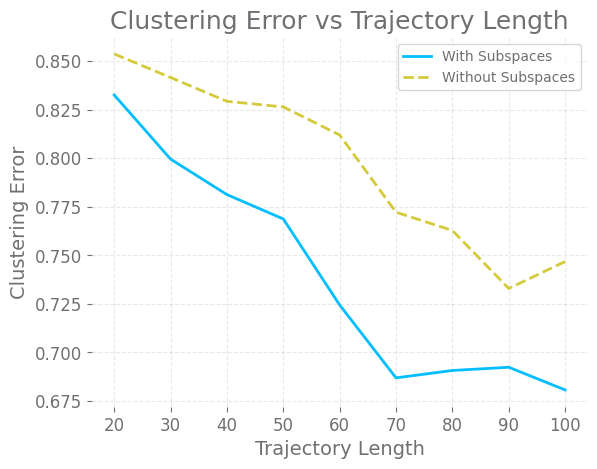

In [17]:
print(np.mean(np.array(clusterAccsTrials),0)[-1])
plt.plot(horizons, 1-np.mean(np.array(clusterAccsTrials),0), label='With Subspaces')
plt.plot(horizons, 1-np.mean(np.array(clusterAccsNoProjsTrials),0), label='Without Subspaces',
        linestyle='--')
plt.ylabel("Clustering Error")
plt.xlabel("Trajectory Length")
plt.title("Clustering Error vs Trajectory Length")
plt.legend()
plt.savefig('figs/figsMC/clustMC.png')

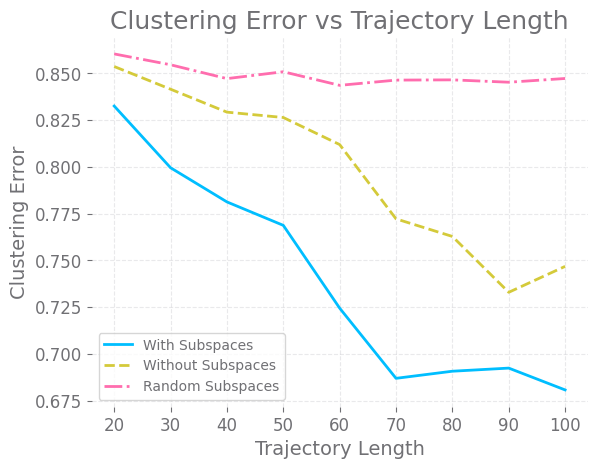

In [18]:
#plt.figure(figsize=(16,9))
plt.plot(horizons, 1-np.mean(np.array(clusterAccsTrials),0), label='With Subspaces')
plt.plot(horizons, 1-np.mean(np.array(clusterAccsNoProjsTrials),0), label='Without Subspaces',
        linestyle='--')
plt.plot(horizons, 1-np.mean(np.array(clusterAccsRandProjsTrials),0), label='Random Subspaces',
        linestyle='dashdot')
plt.ylabel("Clustering Error")
plt.xlabel("Trajectory Length")
plt.title("Clustering Error vs Trajectory Length")
plt.legend()
plt.savefig('figs/figsMC/clustRandMC.png')

100%|██████████| 100/100 [00:00<00:00, 3192.89it/s]


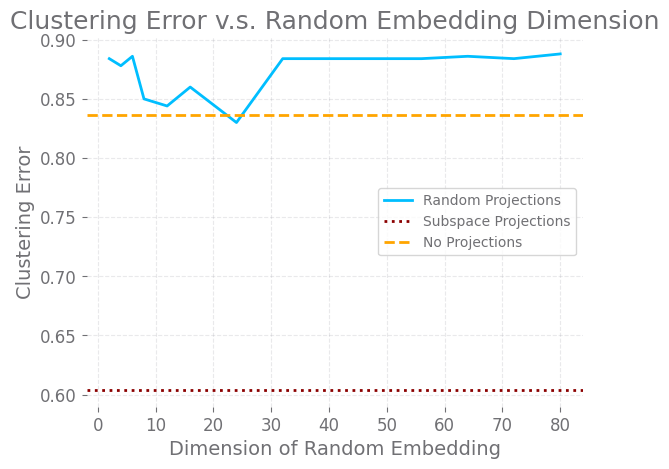

In [20]:
randAccs = []
dims = [2,4,6,8,12,16,24,32,40,48,56,64,72,80]
for dim in dims:
    randProjs = np.linalg.qr(np.random.normal(size=(nStates,nActions,nStates,dim)))[0]
    statRandProjs = computeStat(hs, 
                            randProjs, numpy=False, smalldata=False, device=device, proj=True)
    clusterRands = sklearn.cluster.spectral_clustering((statRandProjs < .5e-5).astype(int), n_clusters=2,
                                                         assign_labels='kmeans')
    randAccs.append(getAcc(clusterRands, labels[sz:], K))
        
#clusterDiagnostics(statRandProjs, K=K, labels=confounders[sz:, 0],
#               lo=0, hi=0.0005, step=0.000025) #0,0.01, 0.0001
#plt.show()
plt.plot(dims, 1-np.array(randAccs), label='Random Projections')
plt.axhline(1-clusterAccs[-1], color='darkred', linestyle='dotted', label='Subspace Projections')
plt.axhline(1-clusterAccsNoProjs[-1], color='orange', linestyle='dashed', label='No Projections')
plt.xlabel('Dimension of Random Embedding')
plt.ylabel('Clustering Error')
plt.title('Clustering Error v.s. Random Embedding Dimension')
plt.legend()
plt.savefig('figs/figsMC/jlRandEmbeddingMC.png')

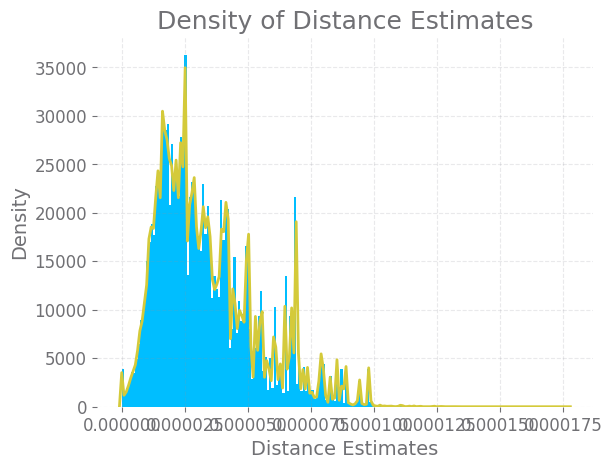

In [22]:
import seaborn as sns
#plt.figure(figsize=(16,9))
plt.hist(statmns.flatten(), bins=200, density=True)#[1]
#plt.hist(statmns.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
sns.kdeplot(statmns.flatten(), bw_adjust=0.2)
#plt.title('')
plt.xlabel('Distance Estimates')
plt.ylabel('Density')
plt.title('Density of Distance Estimates')
plt.savefig('figs/figsMC/distDensMC.png')
plt.show()

100%|██████████| 41/41 [00:01<00:00, 22.88it/s]


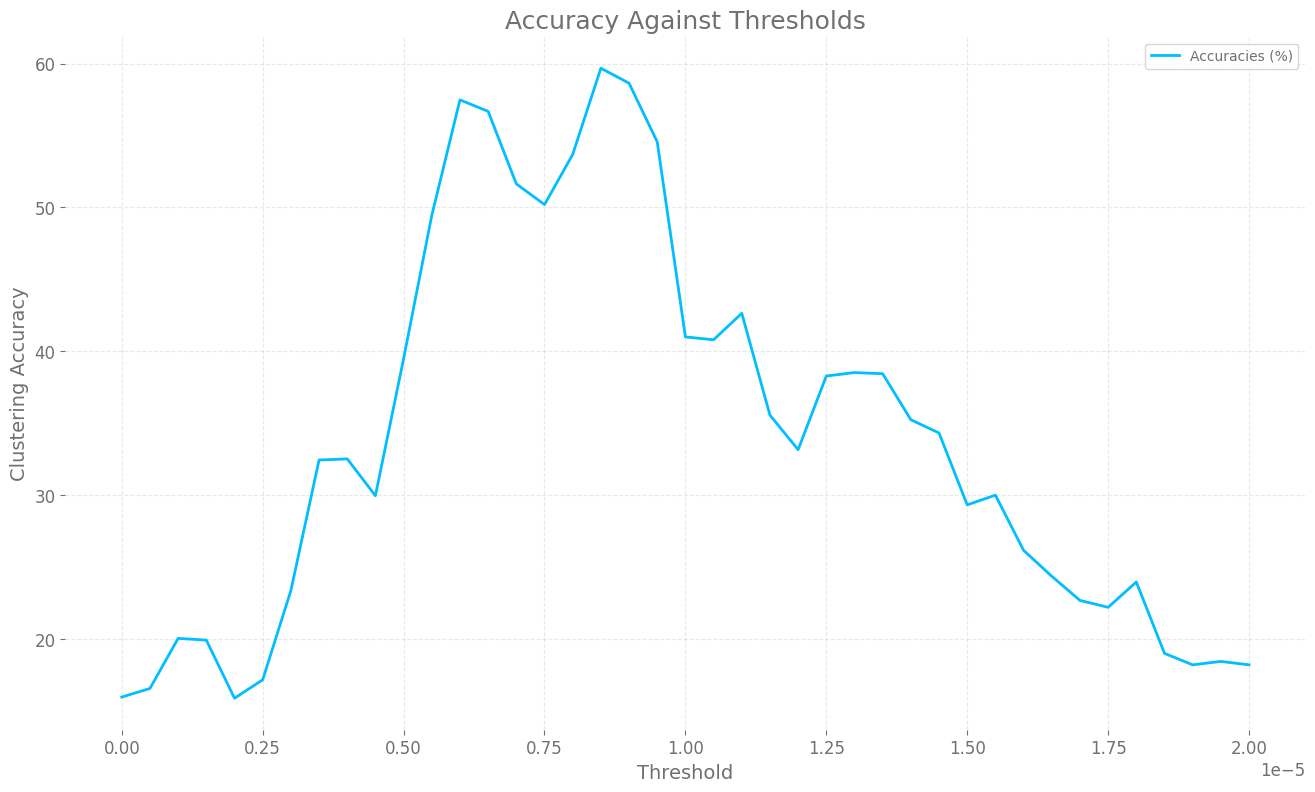

In [24]:
clusterDiagnostics(statmns, K=K, labels=labels[sz:],
                           lo=0, hi=0.00002, step=0.0000005, trials=5)
plt.ylabel('Clustering Accuracy')
plt.title('Accuracy Against Thresholds')
plt.savefig('figs/figsMC/clustAccsMC.png')

0.15164444444444447
0.152
0.16133333333333333


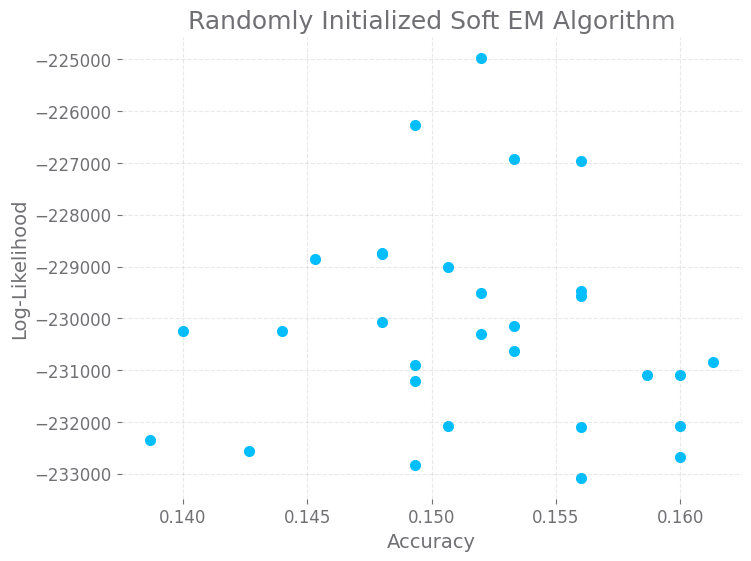

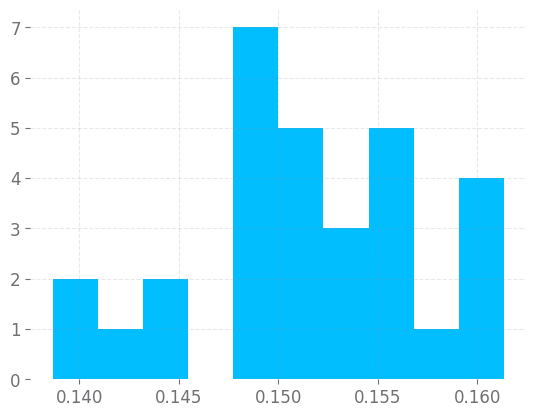

In [25]:
plt.figure(figsize=(8,6))
plt.scatter([getAcc(i, labels, K) for i in np.array(labelsemsoft).argmax(axis=1)], 
            logliksemsoft)
print(np.mean([getAcc(i, labels, K) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.median([getAcc(i, labels, K) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.max([getAcc(i, labels, K) for i in np.array(labelsemsoft).argmax(axis=1)]))
plt.ticklabel_format(style='plain',useOffset=False)
plt.xlabel('Accuracy')
plt.ylabel('Log-Likelihood')
plt.title('Randomly Initialized Soft EM Algorithm')
plt.savefig('figs/figsMC/softEMMC.png')
plt.show()
plt.hist([getAcc(i, labels, K) for i in np.array(labelsemsoft).argmax(axis=1)])
plt.show()

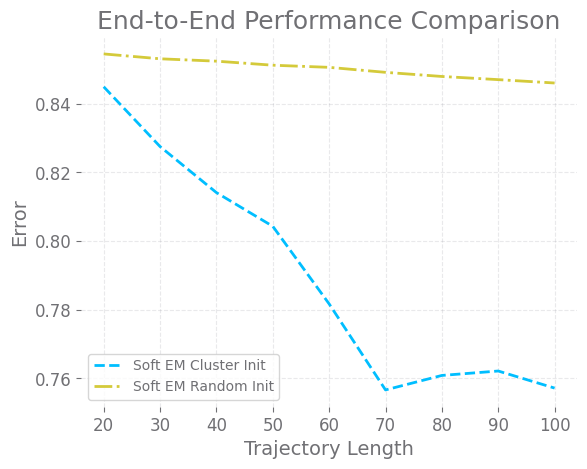

In [31]:
#plt.figure(figsize=(16,9))
'''
plt.plot(horizons, 1-np.median(np.array(hardClustEMAccsTrials),0),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.median(np.array(hardEMAccsTrials),0),
        label='Hard EM')
'''  
plt.plot(horizons, 1-np.mean(np.array(softClustEMAccsTrials),0),
         label='Soft EM Cluster Init',
        linestyle='--')
plt.plot(horizons, 1-np.mean(np.array(softEMAccsTrials),0),
        label='Soft EM Random Init',
        linestyle='dashdot')
#plt.plot(horizons, 1-np.mean(np.array(hardClustEMAccsTrials),0),
#         label='Hard EM Cluster Init',
#        linestyle='--')
#plt.plot(horizons, 1-np.mean(np.array(hardEMAccsTrials),0),
#        label='Hard EM Random Init',
#        linestyle='dashdot')
plt.ylabel("Error")
plt.xlabel("Trajectory Length")
plt.title("End-to-End Performance Comparison")
plt.legend()
plt.savefig('figs/figsMC/emClustMC.png')

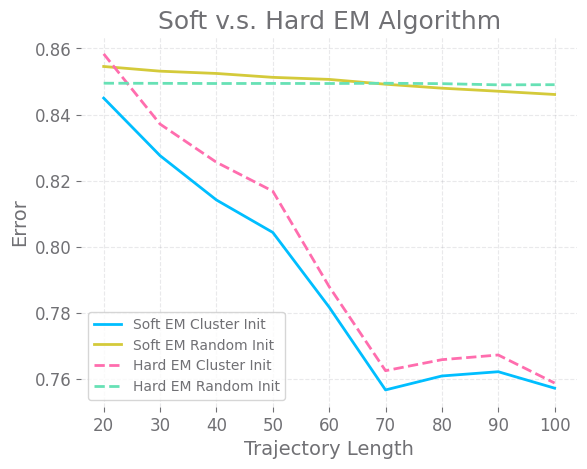

In [33]:
#plt.figure(figsize=(16,9))
'''
plt.plot(horizons, 1-np.median(np.array(hardClustEMAccsTrials),0),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.median(np.array(hardEMAccsTrials),0),
        label='Hard EM')
'''  
plt.plot(horizons, 1-np.mean(np.array(softClustEMAccsTrials),0),
         label='Soft EM Cluster Init')
plt.plot(horizons, 1-np.mean(np.array(softEMAccsTrials),0),
        label='Soft EM Random Init')
plt.plot(horizons, 1-np.mean(np.array(hardClustEMAccsTrials),0),
         label='Hard EM Cluster Init',
        linestyle='--')
plt.plot(horizons, 1-np.mean(np.array(hardEMAccsTrials),0),
        label='Hard EM Random Init',
        linestyle='--')
plt.ylabel("Error")
plt.xlabel("Trajectory Length")
plt.title("Soft v.s. Hard EM Algorithm")
plt.legend()
plt.savefig('figs/figsMC/emSoftHardMC.png')

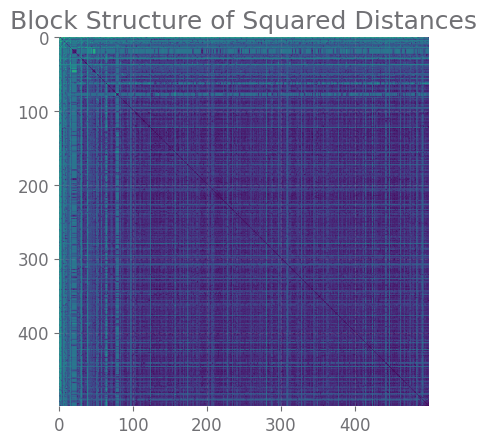

In [34]:
from scipy.cluster.hierarchy import linkage

m = 1-statmns #need similarity matrix
# shuffle
perm = np.random.permutation(len(m))
m = m[perm][:, perm]

# reorder
y = m[np.triu_indices(len(m), k=1)]
Z = linkage(y, method='single', optimal_ordering=True)
perm = np.ravel(Z[:, :2]).astype(np.int32)
perm = perm[perm < len(m)]
m = m[perm][:, perm]

#plt.figure(figsize=(16,9))
plt.imshow(1-m)
plt.title('Block Structure of Squared Distances')
plt.savefig('figs/figsMC/blocksMC.png')

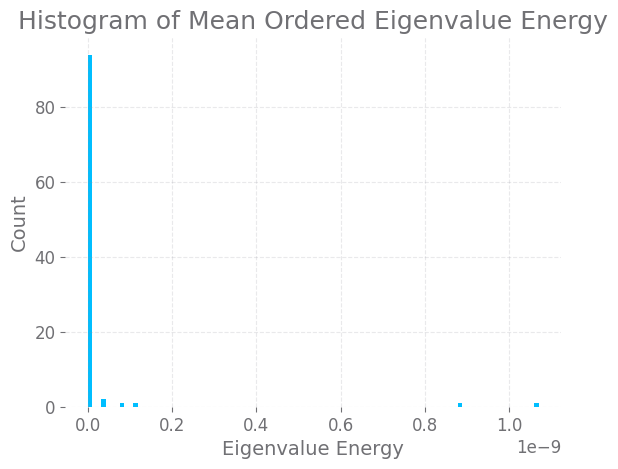

In [35]:
vals, vecs = getEig(onehotsa[:sz], onehotsp[:sz], omegaone, omegatwo, 10000, wt=True)
plt.hist((np.sort(vals, axis=-1)**2).mean((0,1)), bins=nStates)
plt.title('Histogram of Mean Ordered Eigenvalue Energy')
plt.ylabel('Count')
plt.xlabel('Eigenvalue Energy')
plt.savefig('figs/figsMC/eigEnergyMC.png')
plt.show()